In [14]:
# importing libraries 
from sklearn.ensemble import VotingClassifier ,BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score 
from numpy import mean,std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.datasets import load_wine,load_iris
from matplotlib.pyplot import figure
figure(num=2, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
import xgboost as xgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression,BayesianRidge,ElasticNet,Lasso,SGDRegressor,Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,RobustScaler,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA,KernelPCA
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor,VotingClassifier
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,RandomizedSearchCV,StratifiedKFold,train_test_split
from sklearn.base import BaseEstimator,clone,TransformerMixin,RegressorMixin
from sklearn.svm import LinearSVR,SVR
#import xgboost 
from xgboost import XGBRegressor
#Import Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline
seed = 1075
np.random.seed(seed)

<Figure size 1280x960 with 0 Axes>

In [15]:
# loading iris dataset 
iris = load_iris() 
X = iris.data[:, :4] 
Y = iris.target 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20,random_state = 42) 

In [17]:
# Ensemble of Models 
estimator = [] 
estimator.append(('LR',LogisticRegression(solver ='lbfgs',multi_class ='multinomial',max_iter = 200))) 
estimator.append(('SVC', SVC(gamma ='auto', probability = True))) 
estimator.append(('DTC', DecisionTreeClassifier())) 

### Voting Classifier
supports two types of votings.

### Hard Voting:
In hard voting, the predicted output class is a class with the highest majority of votes i.e the class which had the highest probability of being predicted by each of the classifiers. Suppose three classifiers predicted the output class(A, A, B), so here the majority predicted A as output. Hence A will be the final prediction.


In [18]:
# Voting Classifier with hard voting 
hard_voting = VotingClassifier(estimators = estimator, voting ='hard') 
hard_voting.fit(X_train, y_train) 
y_pred = hard_voting.predict(X_test)   

In [19]:
# accuracy_score metric to predict Accuracy 
score = accuracy_score(y_test, y_pred) 
print("Hard Voting Score % d" % score) 

Hard Voting Score  1


### Soft Voting:
In soft voting, the output class is the prediction based on the average of probability given to that class. Suppose given some input to three models, the prediction probability for class A = (0.30, 0.47, 0.53) and B = (0.20, 0.32, 0.40). So the average for class A is 0.4333 and B is 0.3067, the winner is clearly class A because it had the highest probability averaged by each classifier.

In [20]:
# Voting Classifier with soft voting 
soft_voting = VotingClassifier(estimators = estimator, voting ='soft') 
soft_voting.fit(X_train, y_train) 
y_pred = soft_voting.predict(X_test) 

In [21]:
# Using accuracy_score 
score = accuracy_score(y_test, y_pred) 
print("Soft Voting Score % d" % score) 

Soft Voting Score  1


In practical the output accuracy will be more for soft voting as it is the average probability of the all estimators combined, as for our basic iris dataset we are already overfitting, so there won’t be much difference in output.

##### Averaging 

Multiple predictions are made for each data point in averaging. In this method, we take an average of predictions from all the models and use it to make the final prediction. Averaging can be used for making predictions in regression problems or while calculating probabilities for classification problems.

The simplest way to develop a model averaging ensemble in Keras is to train multiple models on the same dataset then combine the predictions from each of the trained models.

We will use a small multi-class classification problem as the basis to demonstrate a model averaging ensemble.

The scikit-learn class provides the make_blobs() function that can be used to create a multi-class classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class.

We use this problem with 500 examples, with input variables to represent the x and y coordinates of the points and a standard deviation of 2.0 for points within each group. We will use the same random state to ensure that we always get the same 500 points.

In [22]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

In [23]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

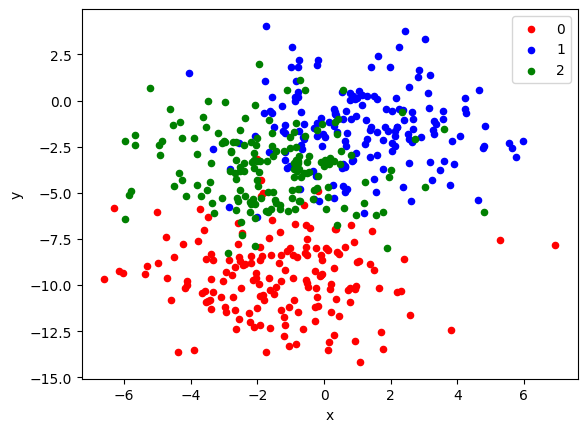

In [24]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line) causing many ambiguous points.

**So in summary for every instance of test dataset, the average predictions are calculated. This method often reduces overfit and creates a smoother regression model.**

Weighted Averaging
This is an extension of the averaging method. All models are assigned different weights defining the importance of each model for prediction. 
For this we will use the housing prices dataset to demonstrate as shown below

Firstly import the libraries & data 

In [25]:
train = pd.read_csv('train.csv',na_values = '#NAME?')
test = pd.read_csv('test.csv',na_values = '#NAME?')

    Based on the distribution of data let us remove some of the outliers

In [26]:
train.drop(train[(train['GrLivArea'] >4000) & (train['SalePrice']<300000)].index,inplace = True)

Let us concatenate both the training and test datasets into a single dataframe for ease of data cleaning and feature engineering.'Id' feature has no significance to our modelling since it is a continuous variable ,so dropping this feature on both train and test datasets.

In [27]:
full = pd.concat([train,test],ignore_index=True)
full.drop('Id',axis = 1,inplace = True)
full.shape

(2917, 80)

Now let us preprocess the data by doing some missing values treatment

In [28]:
missing_values = full.isnull().sum()
missing_values[missing_values>0].sort_values(ascending = False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
GarageCars         1
KitchenQual        1
GarageArea         1
SaleType           1
dtype: int64

let us impute the missing values of LotFrontage based on the median of LotArea and Neighborhood. To achieve this let us first group Neighborhood and LotFrontage with respect to median,mean and count.

In [29]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

LotArea is a continuous feature so it is best to use panda's qcut method to divide it into 10 parts.

In [30]:
full['LotAreaCut'] = pd.qcut(full.LotArea,10)

full.groupby([full['LotAreaCut']])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

So let us impute the missing values of LotFrontage as stated above with the median of LotArea and Neighborhood.

In [31]:
full['LotFrontage']= full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))
full['LotFrontage']= full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))

Now let us recheck the missing values to see our LotFrontage missing values are imputed successfully.

In [32]:
missing_values = full.isnull().sum()

missing_values[missing_values>0].sort_values(ascending = False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
GarageCars         1
KitchenQual        1
GarageArea         1
SaleType           1
dtype: int64

Now let us focus on numerical features with one missing value and replace them with 0

In [33]:
columns = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in columns:full[col].fillna(0,inplace= True)

Now let us focus on some of the categorical features with major count of missing values and replace them with 'None'

In [34]:
columns1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish",
"GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col1 in columns1:full[col1].fillna('None',inplace = True)

Now let us focus on some of the categorical features with fewer missing values and replace them with the most frequently occured value which is the mode of that feature.

In [35]:
columns2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional",
            "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]

for col2 in columns2:
    full[col2].fillna(full[col2].mode()[0],inplace = True)

Now let us recheck if we have any other missing values that needs to be imputed except the SalePrice for the test dataset which is the target variable to be determined.

In [36]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

In [37]:
numeric_features = full.select_dtypes(include=[np.number])
numeric_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [38]:
Numstr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold",
          "YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]

for i in Numstr:
    full[i]=full[i].astype(str)

In [39]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

In [40]:
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"


In [41]:
map_values()

'Done!'

In [42]:
# drop two unwanted columns
full.drop("LotAreaCut",axis=1,inplace=True)

full.drop(['SalePrice'],axis=1,inplace=True)

In [43]:
full[['YearBuilt','YearRemodAdd','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
0,2003,2003,2003.0
1,1976,1976,1976.0
2,2001,2002,2001.0
3,1915,1970,1998.0
4,2000,2000,2000.0


Let us create a class for the LabelEncoder to fit and transform some of the identified features

In [44]:
class labenc(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        label = LabelEncoder()
        X['YearBuilt']=label.fit_transform(X['YearBuilt'])
        X['YearRemodAdd']=label.fit_transform(X['YearRemodAdd'])
        X['GarageYrBlt']=label.fit_transform(X['GarageYrBlt'])
        return X
        

In [45]:
class skewness(BaseEstimator,TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        return X

In [46]:
class dummies(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X = pd.get_dummies(X)
        return X

Now we will use pipeline to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves two purposes here:

Convenience: You only have to call fit and predict once on your data to fit a whole sequence of estimators.
Joint parameter selection: You can grid search over parameters of all estimators in the pipeline at once.
All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

In [47]:
pipeline = Pipeline([('labenc',labenc()),('skewness',skewness(skew =1)),('dummies',dummies())])

In [48]:
full_copy = full.copy()
data_pipeline = pipeline.fit_transform(full_copy)

In [49]:
robust_scaler = RobustScaler()

In [50]:
n_train = train.shape[0]
n_train

1458

In [51]:
X= data_pipeline[:n_train]
y = train.SalePrice
test_X = data_pipeline[n_train:]
X.shape,y.shape,test_X.shape

((1458, 405), (1458,), (1459, 405))

In [52]:
X_scaled = robust_scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = robust_scaler.transform(test_X)

In [53]:
X_scaled.shape,y_log.shape,test_X.shape

((1458, 405), (1458,), (1459, 405))

Now we will perform some feature selection like Lasso 

In [54]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [55]:
pipeline = Pipeline([('labenc',labenc()),('add_feature', add_feature(additional=2)),
                     ('skewness',skewness(skew =1)),('dummies',dummies())])

full_pipe = pipeline.fit_transform(full)
full_pipe.shape

(2917, 426)

In [56]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = robust_scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = robust_scaler.transform(test_X)

In [57]:
print(X_scaled.shape)

(1458, 426)


In [58]:
# Now let us define Root Mean Square Error 
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=5))
    return rmse

We choose 4 models and use 5-folds cross-calidation to evaluate these models.

### Models include:

   - LinearRegression
   - Ridge
   - Lasso
   - Random Forest

In [59]:
models = [LinearRegression(),
             Ridge(),
             Lasso(alpha=0.01,max_iter=10000),
             RandomForestRegressor(),
             GradientBoostingRegressor(),
             SVR(),
             LinearSVR(),
             ElasticNet(alpha = 0.001,max_iter=10000),
             SGDRegressor(max_iter=1000, tol = 1e-3),
             BayesianRidge(),
             KernelRidge(alpha=0.6,kernel='polynomial',degree = 2,coef0=2.5),
             ExtraTreesRegressor(),
             XGBRegressor()
             ]

In [60]:
names = ['LR','Ridge','Lasso','RF','GBR','SVR','LSVR','ENet','SGDR','BayRidge','Kernel','XTreeR','XGBR']

In [61]:
for model,name in zip(models,names):
    score = rmse_cv(model,X_scaled,y_log)
    print("{}: {:.6f}, {:4f}".format(name,score.mean(),score.std()))

LR: 7696373950.982149, 14934771811.116056
Ridge: 0.117596, 0.009054
Lasso: 0.120932, 0.005813
RF: 0.131029, 0.007191
GBR: 0.121335, 0.004460
SVR: 0.131747, 0.010868
LSVR: 0.126264, 0.007887
ENet: 0.108729, 0.005422
SGDR: 0.298565, 0.008996
BayRidge: 0.110576, 0.005997
Kernel: 0.109421, 0.005545
XTreeR: 0.125309, 0.007176
XGBR: 0.132300, 0.004476


In [62]:
# To define the average weight 
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,model,weight):
        self.model = model
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.model]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [63]:
lasso = Lasso(alpha= 0.0005, max_iter= 10000)
ridge = Ridge(alpha=45, max_iter= 10000)
svr = SVR(C = 0.2, epsilon= 0.025, gamma = 0.0004, kernel = 'rbf')
ker = KernelRidge(alpha=0.15 ,kernel='polynomial',degree=3 , coef0=0.9)
ela = ElasticNet(alpha=0.0065,l1_ratio=0.075,max_iter=10000)
bay = BayesianRidge()

#### Finally to calculate the average weights let us look at the following code

In [64]:
# Assign weights to all the above 6 models
w1 = 0.047
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.003
w6 = 0.2

weight_avg = AverageWeight(model = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.10924398896075178


If we consider only two models then the score will vary

In [65]:
weight_avg = AverageWeight(model = [svr,ker],weight=[0.50,0.50])
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.11166439558199077


So in summary Weighted averaging is a slightly modified version of simple averaging, where the prediction of each model is multiplied by the weight and then their average is calculated. 

Stacking 
Stacking is an ensemble learning technique that uses predictions from multiple models (for example decision tree, knn or svm) to build a new model. This model is used for making predictions on the test set.

Stacking, also known as Stacked Generalization is an ensemble technique that combines multiple classifications or regression models via a meta-classifier or a meta-regressor. The base-level models are trained on a complete training set, then the meta-model is trained on the features that are outputs of the base-level model. The base-level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous. Here is a diagram illustrating the process


In [66]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [67]:
from sklearn.impute import SimpleImputer

In [68]:
X_scaled_imputed = SimpleImputer().fit_transform(X_scaled)
y_log_imputed = SimpleImputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [69]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [70]:
score = rmse_cv(stack_model,X_scaled_imputed,y_log_imputed)

In [71]:
print(score.mean())

nan


Blending 
Blending follows the same approach as stacking but uses only a holdout (validation) set from the train set to make predictions. In other words, unlike stacking, the predictions are made on the holdout set only. The holdout set and the predictions are used to build a model which is run on the test set. 

In [72]:
from sklearn.datasets import load_wine
# define dataset
X,y = load_wine().data,load_wine().target

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)

In [74]:
x_val=pd.DataFrame(X_val)
x_test=pd.DataFrame(X_test)

In [75]:
model1 = DecisionTreeClassifier()
model1.fit(X_train, y_train)
val_pred1=model1.predict(X_val)
test_pred1=model1.predict(X_test)
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)

model2 = KNeighborsClassifier()
model2.fit(X_train,y_train)
val_pred2=model2.predict(X_val)
test_pred2=model2.predict(X_test)
val_pred2=pd.DataFrame(val_pred2)
test_pred2=pd.DataFrame(test_pred2)

Combining the meta-features and the validation set, a logistic regression model is built to make predictions on the test set.

In [76]:
df_val=pd.concat([x_val, val_pred1,val_pred2],axis=1)
df_test=pd.concat([x_test, test_pred1,test_pred2],axis=1)

model = LogisticRegression()
model.fit(df_val,y_val)
model.score(df_test,y_test)

0.9166666666666666

Bagging 
**Bagging**, is shorthand for the combination of bootstrapping and aggregating. Bootstrapping is a method to help decrease the variance of the classifier and reduce overfitting, by resampling data from the training set with the same cardinality as the original set. The model created should be less overfitted than a single individual model.

A high variance for a model is not good, suggesting its performance is sensitive to the training data provided. So, even if more the training data is provided, the model may still perform poorly. And, may not even reduce the variance of our model.

Bagging is an effective method when you have limited data, and by using samples you’re able to get an estimate by aggregating the scores over many samples.

The simplest approach with bagging is to use a couple of small subsamples and bag them, if the ensemble accuracy is much higher than the base models, it’s working; if not, use larger subsamples.Using larger subsamples is not guaranteed to improve your results. In bagging there is a tradeoff between base model accuracy and the gain you get through bagging. The aggregation from bagging may improve the ensemble greatly when you have an unstable model, yet when your base models are more stable — been trained on larger subsamples with higher accuracy — improvements from bagging reduces.

Once the bagging is done, and all the models have been created on (mostly) different data, a weighted average is then used to determine the final score.

There are three main terms describing the ensemble (combination) of various models into one more effective model:

* **Bagging** to decrease the model’s variance;
* **Boosting** to decreasing the model’s bias, and;
* **Stacking** to increasing the predictive force of the classifier.

The idea behind bagging is combining the results of multiple models (for instance, all decision trees) to get a generalized result. Here’s a question: If you create all the models on the same set of data and combine it, will it be useful? There is a high chance that these models will give the same result since they are getting the same input. So how can we solve this problem? One of the techniques is bootstrapping.

Bootstrapping is a sampling technique in which we create subsets of observations from the original dataset, with replacement. The size of the subsets is the same as the size of the original set.

Bagging (or Bootstrap Aggregating) technique uses these subsets (bags) to get a fair idea of the distribution (complete set). The size of subsets created for bagging may be less than the original set.
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image20-768x289.png)

Step 1: Multiple subsets are created from the original dataset, selecting observations with replacement.

Step 2: A base model (weak model) is created on each of these subsets.

Step 3: The models run in parallel and are independent of each other.

Step 4: The final predictions are determined by combining the predictions from all the models.
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/Screenshot-from-2018-05-08-13-11-49-768x580.png)

In [77]:
from sklearn.datasets import load_wine
# define dataset
X,y = load_wine().data,load_wine().target

In [78]:
# Create classifiers
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()
clf_array = [rf, et, knn, svc, rg]
for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X, y, cv=10, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf,max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10,n_jobs=-1)
    
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__,vanilla_scores.mean(), vanilla_scores.std()))
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.983, std: (+/-) 0.025 [RandomForestClassifier]
Mean of: 0.972, std: (+/-) 0.028 [Bagging RandomForestClassifier]

Mean of: 0.989, std: (+/-) 0.022 [ExtraTreesClassifier]
Mean of: 0.983, std: (+/-) 0.025 [Bagging ExtraTreesClassifier]

Mean of: 0.675, std: (+/-) 0.070 [KNeighborsClassifier]
Mean of: 0.764, std: (+/-) 0.068 [Bagging KNeighborsClassifier]

Mean of: 0.681, std: (+/-) 0.087 [SVC]
Mean of: 0.664, std: (+/-) 0.056 [Bagging SVC]

Mean of: 0.983, std: (+/-) 0.025 [RidgeClassifier]
Mean of: 0.983, std: (+/-) 0.025 [Bagging RidgeClassifier]



In all but one of the classifiers, we had lower variance as shown above . As well, the accuracy of classifiers all increased except for SVC. Looks like this bagging thing actually works. 

So our bagged individual classifiers are (mostly) better, but which one do we choose?

**Let’s Vote!**

Sklearn’s **VotingClassifier** allows you to combine different machine learning classifiers, and perform a vote on what the predicted class label(s) are for a record.

There are two types of voting you can do for classifiers: hard and soft.

With hard voting, you just need a majority of classifiers to determine what the result could be. As with the image below, the various bagged models are shown with H, and the results of the classifiers are shown on the rows. On the far right, H1 and H3 vote for the first record to be “no” (purple) while H2 votes for “yes” (yellow). Because 2 of the models vote for “no”, the ensemble classifies that record as a “no”.


With soft (weighted), we compute a percentage weight with each classifier. A predicted class probability from each model for each record is collected and multiplied by the classifier weight, and finally averaged. The final class label is then derived from the class label with the highest average probability.

In reality weights are hard to find if you’re just providing your best guesses to which model you think should be weighted more or less. To counter this subjective process, a linear optimization equation or neural net could be constructed to find the correct weighting for each of the models to optimize the accuracy of the ensemble.

In [79]:
from sklearn.ensemble import VotingClassifier
clf = [rf, et, knn, svc, rg]
eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')
for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.98 (+/- 0.03) [Random Forest]
Accuracy: 0.99 (+/- 0.02) [Extra Trees]
Accuracy: 0.68 (+/- 0.07) [KNeighbors]
Accuracy: 0.68 (+/- 0.09) [SVC]
Accuracy: 0.98 (+/- 0.03) [Ridge Classifier]
Accuracy: 0.99 (+/- 0.02) [Ensemble]


With our bagged ensemble results shown above, we have an increase in accuracy and a decrease in variance, so our ensemble model is working as expected after we’ve combined all the various models into one.

Now that we know how well our model(s) are doing individually and together, does that actually look. 

Boosting 
The main idea of boosting is to add additional models to the overall ensemble model sequentially. Previously with bagging, we averaged each individual model created. This time with each iteration of boosting, a new model is created and the new base-learner model is trained (updated) from the errors of the previous learners.

The algorithm creates multiple weak models whose output is added together to get an overall prediction. This is ensemble modelling from earlier. The now boosted gradient shifts the current prediction nudging it to the true target, in a similar fashion to how gradient descent moves toward the true values. The gradient descent optimization occurs on the output of the varies models, and not their individual parameters.

There are different methods to optimize boosting algorithms.
Unlike the bagging examples above, classical boosting the subset creation is not random and performance will depend upon the performance of previous models. As, each new subset which is iterated upon contains elements which could have been misclassified by previous models. We will also be using the same hard voting we used previously to ensemble the models together.

In [80]:
from sklearn.datasets import load_wine
# define dataset
X,y = load_wine().data,load_wine().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

**Adaptive boosting** or **AdaBoost** is one of the simplest boosting algorithms. Usually, decision trees are used for modelling. Multiple sequential models are created, each correcting the errors from the last model. AdaBoost assigns weights to the observations which are incorrectly predicted and the subsequent model works to predict these values correctly.

Below are the steps for performing the AdaBoost algorithm:

* Initially, all observations in the dataset are given equal weights.
* A model is built on a subset of data.
* Using this model, predictions are made on the whole dataset.
* Errors are calculated by comparing the predictions and actual values.
* While creating the next model, higher weights are given to the data points which were predicted incorrectly.
* Weights can be determined using the error value. For instance, higher the error more is the weight assigned to the observation.
* This process is repeated until the error function does not change, or the maximum limit of the number of estimators is reached.

In [81]:
ada_boost = AdaBoostClassifier(random_state=1)
ada_boost.fit(X_train, y_train)
ada_boost.score(X_test,y_test)

0.8333333333333334

**Parameters**

**base_estimators**:

* It helps to specify the type of base estimator, that is, the machine learning algorithm to be used as base learner.

**n_estimators**:

* It defines the number of base estimators.
* The default value is 10, but you should keep a higher value to get better performance.

**learning_rate**:

* This parameter controls the contribution of the estimators in the final combination.
* There is a trade-off between learning_rate and n_estimators.

**max_depth**:

* Defines the maximum depth of the individual estimator.
* Tune this parameter for best performance.

**n_jobs**

* Specifies the number of processors it is allowed to use.
* Set value to -1 for maximum processors allowed.

**random_state** :

* An integer value to specify the random data split.
* A definite value of random_state will always produce same results if given with same parameters and training data.

**Gradient Boosting or GBM ** 

It is another ensemble machine learning algorithm that works for both regression and classification problems. GBM uses the boosting technique, combining a number of weak learners to form a strong learner. Regression trees used as a base learner, each subsequent tree in series is built on the errors calculated by the previous tree.

In [82]:
grad_boost= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
grad_boost.fit(X_train, y_train)
grad_boost.score(X_test,y_test)

0.9444444444444444

**Parameters**

**min_samples_split**

* Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
* Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
 
**min_samples_leaf**

* Defines the minimum samples required in a terminal or leaf node.
* Generally, lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in the majority will be very small.

**min_weight_fraction_leaf**

* Similar to min_samples_leaf but defined as a fraction of the total number of observations instead of an integer.

**max_depth**

* The maximum depth of a tree.
* Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample.
* Should be tuned using CV.
 
**max_leaf_nodes**

* The maximum number of terminal nodes or leaves in a tree.
* Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
* If this is defined, GBM will ignore max_depth.

**max_features**

* The number of features to consider while searching for the best split. These will be randomly selected.
* As a thumb-rule, the square root of the total number of features works great but we should check up to 30-40% of the total number of features.
* Higher values can lead to over-fitting but it generally depends on a case to case scenario.
 

**XGBoost** (extreme Gradient Boosting) is an advanced implementation of the gradient boosting algorithm. XGBoost has proved to be a highly effective ML algorithm, extensively used in machine learning competitions and hackathons. XGBoost has high predictive power and is almost 10 times faster than the other gradient boosting techniques. It also includes a variety of regularization which reduces overfitting and improves overall performance. Hence it is also known as ‘**regularized boosting**‘ technique.

Let us see how XGBoost is comparatively better than other techniques:

**Regularization:**

Standard GBM implementation has no regularisation like XGBoost.
Thus XGBoost also helps to reduce overfitting.

**Parallel Processing:**
* XGBoost implements parallel processing and is faster than GBM .
* XGBoost also supports implementation on Hadoop.

**High Flexibility:**
XGBoost allows users to define custom optimization objectives and evaluation criteria adding a whole new dimension to the model.

**Handling Missing Values:**
XGBoost has an in-built routine to handle missing values.

**Tree Pruning:**
XGBoost makes splits up to the max_depth specified and then starts pruning the tree backwards and removes splits beyond which there is no positive gain.

**Built-in Cross-Validation:**
XGBoost allows a user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.

In [83]:
xgb_boost=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
xgb_boost.fit(X_train, y_train)
xgb_boost.score(X_test,y_test)

0.9166666666666666

**Parameters**

**nthread**

* This is used for parallel processing and the number of cores in the system should be entered..
* If you wish to run on all cores, do not input this value. The algorithm will detect it automatically.

**eta**

Analogous to learning rate in GBM.
Makes the model more robust by shrinking the weights on each step.

**min_child_weight**

* Defines the minimum sum of weights of all observations required in a child.
* Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.

**max_depth**

* It is used to define the maximum depth.
* Higher depth will allow the model to learn relations very specific to a particular sample.

**max_leaf_nodes**

* The maximum number of terminal nodes or leaves in a tree.
* Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
* If this is defined, GBM will ignore max_depth.

**gamma**

* A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
* Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

**subsample**

* Same as the subsample of GBM. Denotes the fraction of observations to be randomly sampled for each tree.
* Lower values make the algorithm more conservative and prevent overfitting but values that are too small might lead to under-fitting.

**colsample_bytree**

* It is similar to max_features in GBM.
* Denotes the fraction of columns to be randomly sampled for each tree.

In [84]:
eclf = VotingClassifier(estimators=[('Ada Boost', ada_boost), ('Grad Boost', grad_boost), ('XG Boost', xgb_boost)], voting='hard')
clf = [rf, et, knn, svc, rg]
for clf, label in zip([ada_boost, grad_boost, xgb_boost,eclf], ['Ada Boost','Grad Boost','XG Boost','Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
   

Accuracy: 0.92 (+/- 0.12) [Ada Boost]
Accuracy: 0.91 (+/- 0.08) [Grad Boost]
Accuracy: 0.93 (+/- 0.07) [XG Boost]
Accuracy: 0.93 (+/- 0.07) [Ensemble]
